In [1]:
##### Header #####
# Performs statistical analysis on all data sets over CA study area

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## FLAGS for processing
flag_getdata = 0              # Load and process raw data (1)? Or load pre-processed data (0)?

## Import statements
# netcdf/numpy/xray
from netCDF4 import num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pickle
import pandas as pd
import xray
import scipy

# OS interaction
import sys
import os

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

## Directory listing
# dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
# dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

dir_data = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'
# dir_MODIS = '/MODIS.IRRAD'

# Directory for basemap pickle files
# dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'
dir_bmap = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Functions
####################################################################################################

In [3]:
##### Basemap
def build_basemap(lon,lat,dir_bmap,bmap_name='basemap.pickle',rewrite=False):
    # Lat/Lon handling - map extent
    bmap_dict = {}
    bmap_dict['lat_i'] = np.min(lat)
    bmap_dict['lon_i'] = np.min(lon)
    bmap_dict['lat_j'] = np.max(lat)
    bmap_dict['lon_j'] = np.max(lon)
    
    bmap_dict['lat_mid'] = lat[np.round(lat.size/2)]
    bmap_dict['lon_mid'] = lon[np.round(lon.size/2)]
    
    bmap_dict['lat_labels'] = np.arange(np.round(bmap_dict['lat_i']), np.round(bmap_dict['lat_j']), 2)
    bmap_dict['lon_labels'] = np.arange(np.round(bmap_dict['lon_i']), np.round(bmap_dict['lon_j']), 2)
    
    os.chdir(dir_bmap)
    # Force rewriting basemap pickle file
    if rewrite:
        bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                        urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                        rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                        lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
        pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    else:
        try:
            bmap = pickle.load(open(bmap_name,'rb'))
        except IOError as e:
            bmap = Basemap(llcrnrlon=bmap_dict['lon_i'],llcrnrlat=bmap_dict['lat_i'],\
                            urcrnrlon=bmap_dict['lon_j'],urcrnrlat=bmap_dict['lat_j'],\
                            rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',\
                            lat_1=bmap_dict['lat_mid'],lon_0=bmap_dict['lon_mid'])
            pickle.dump(bmap,open(bmap_name,'wb'),-1)
    
    return bmap,bmap_dict

In [4]:
##### Re-Gridding Function
# Converts from_xray_ds spatial resolution to to_xray_ds using a nearest neighbor approach.
# Assumes arrays are ['time','lat','lon']
def xray_regrid(from_xray_ds,to_xray_ds,field):
    ## Coordinates to regrid to
    lat_rg = to_xray_ds.latitude.values
    nlat_rg = lat_rg.size
    lon_rg = to_xray_ds.longitude.values
    nlon_rg = lon_rg.size
    lonm_rg,latm_rg = np.meshgrid(lon_rg,lat_rg)
    
    ## Coordinates of original dataset
    lat_g = from_xray_ds.latitude.values
    nlat_g = lat_g.size
    lon_g = from_xray_ds.longitude.values
    nlon_g = lon_g.size
    lonm_g,latm_g = np.meshgrid(lon_g,lat_g)
    latm_g = np.reshape(latm_g[:],(nlat_g*nlon_g,1))
    lonm_g = np.reshape(lonm_g[:],(nlat_g*nlon_g,1))
    
    ## Combine coordinates
    grid_points = np.append(lonm_g[:],latm_g[:],axis=1)
    regrid_points = (lonm_rg,latm_rg)
    
    ## Interpolate in space dimension, along time dimension
    dates = from_xray_ds.time
    regrid = np.empty((dates.size,nlat_rg,nlon_rg))
    for ind,d in enumerate(dates):
        ## Use loc or sel here instead of values w/ indexing
        grid = np.reshape(np.squeeze(from_xray_ds[field].values[ind,:,:]),(nlat_g*nlon_g))
        regrid[ind,:,:] = scipy.interpolate.griddata(grid_points,grid,regrid_points,method='nearest') 
        
    ## Output to xray structure
    regrid_xray_ds = xray.Dataset({field: (['time','latitude','longitude'], regrid)},\
                                  coords={'time': dates,'latitude': lat_rg,'longitude':lon_rg})
    return(regrid_xray_ds)

# To do: handle more than one field/convert entire data structure

In [5]:
##### Discrete colorbar -- from Joe Hamman (https://github.com/jhamman/tonic/blob/master/tonic/plot_utils.py#L66-L94)
def cmap_discretize(cmap, n_colors=10):
    """Return discretized colormap.
    Parameters
    ----------
    cmap : str or colormap object
        Colormap to discretize.
    n_colors : int
        Number of discrete colors to divide `cmap` into.
    Returns
    ----------
    disc_cmap : LinearSegmentedColormap
        Discretized colormap.
    """
    try:
        cmap = cm.get_cmap(cmap)
    except:
        cmap = cm.get_cmap(eval(cmap))
    colors_i = np.concatenate((np.linspace(0, 1., n_colors), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., n_colors + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki])
                      for i in range(n_colors + 1)]

    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % n_colors,
                                              cdict, 1024)

In [112]:
#### Function for combining xray data variables into a single array with new labeled dimension
def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
    ds_out = xray.Dataset()
    ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
    ds_out = ds_out.rename({'new_dim': new_dim_name})
    ds_out.coords[new_dim_name] = dat_vars
    ds_out.name = combinevarname

    return ds_out

In [6]:
####################################
## Read previously processed data ##
####################################
# ///// See CC.CA.StatisticsMaps.Master for details on creation of xray data 

###########
## NLDAS ##
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})

#########
## SYN ##
os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.monthly.nc')
syn.longitude.values = syn.longitude.values-360
syn.latitude.values = syn.latitude.values[::-1]
# Flip the syn array spatially
for d in np.arange(syn.time.size):
    syn.SWdwn.values[d-1,:,:] = np.flipud(syn.SWdwn.values[d-1,:,:])
    syn.LWdwn.values[d-1,:,:] = np.flipud(syn.LWdwn.values[d-1,:,:])

############
## MTCLIM ##
os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')

#########################
## Ground Observations ##
os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs.irrad.monthly.nc')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

#########
## WRF ##
os.chdir(dir_data+dir_WRF)
wrf = xray.open_dataset('CA.WRF.irrad.monthly.nc')
wrf = wrf.rename({'lon':'longitude','lat':'latitude'})


In [7]:
### Re-grid to mtclim spatial scale
# Q: do all coordinates represent the same thing? (e.g., lat-lon = lower left corner? 
# Should I convert to center of grid labeling scheme?
regrid_ds = {}
regrid_ds['nldas'] = xray_regrid(nldas,wrf,'SWdwn')
regrid_ds['syn'] = xray_regrid(syn,wrf,'SWdwn')
regrid_ds['mtclim'] = xray_regrid(mtclim,wrf,'SWdwn')
regrid_ds['wrf'] = wrf

# Describe product names for iteration
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)

### Aligned xray Dataset structure
align_ds = xray.Dataset()
for pr in pr_names:
    align_ds[pr] = regrid_ds[pr].SWdwn
    
# regrid_ds['modis'] = xray_regrid(modis,mtclim,'SWdwn')
# regrid_ds['modis'].SWdwn.loc['latitude' < modis.latitude.values.min()] = np.nan

In [8]:
print(align_ds)

<xray.Dataset>
Dimensions:    (latitude: 121, longitude: 120, time: 144)
Coordinates:
  * latitude   (latitude) float32 34.5252 34.5791 34.633 34.6869 34.7408 ...
  * longitude  (longitude) float32 -123.48 -123.416 -123.352 -123.288 ...
  * time       (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
Data variables:
    mtclim     (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    nldas      (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    syn        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    wrf        (time, latitude, longitude) float64 nan nan nan nan nan nan ...


2006-04-30 00:00:00
Monthly values - mtclim
Monthly values - nldas
Monthly diffs - nldas
Monthly values - syn
Monthly diffs - syn
Monthly values - wrf
Monthly diffs - wrf
2006-05-31 00:00:00
Monthly values - mtclim
Monthly values - nldas
Monthly diffs - nldas
Monthly values - syn
Monthly diffs - syn
Monthly values - wrf
Monthly diffs - wrf


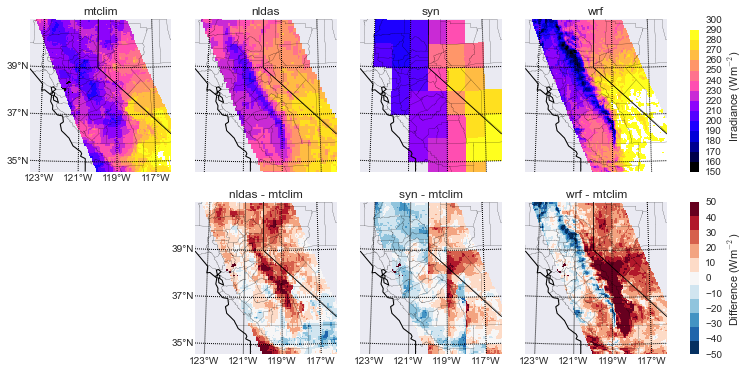

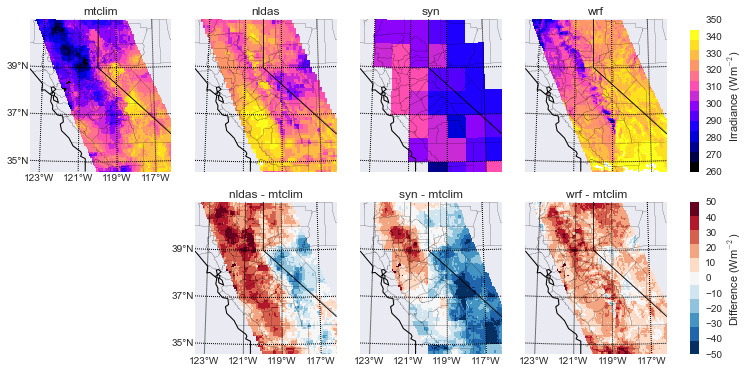

In [24]:
#####################################################
###### Plot differences from mtclim (no modis) ######
## plotting variables, coordinates, basemap
# colors
SWmin_delta = -50
SWmax_delta = 50
cmap = cmap_discretize(cm.gnuplot2,15)
cmap_delta = cmap_discretize(cm.RdBu_r,11)

# Build basemap
lat = regrid_ds['mtclim'].latitude.values
lon = regrid_ds['mtclim'].longitude.values

bmp,bmd = build_basemap(lon,lat,dir_bmap,'CA.Domain.bmp.pickle',rewrite=True)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']

## Loop through dates
for d in pd.date_range(start='2006-04-01',end='2006-06-01',freq='M'):
    print(d)
    # Create figure properties
    fig = plt.figure(figsize=(12,6))
#     gs = matplotlib.gridspec.GridSpec(2,5,width_ratios=[16,16,16,16,1])
    gs = matplotlib.gridspec.GridSpec(2,num_products+1,width_ratios=np.append(np.ones(num_products)*16,np.array(1.)))

    ## Color range
    SWmax = 0
    SWmin = 500
    for pr in pr_names:
        if regrid_ds[pr].SWdwn.loc[d:d].any() \
            and not np.isnan(np.nanmax(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values))).any():
            SWmax = max(np.nanmax(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values)),SWmax)
            SWmax = np.round(SWmax/10)*10
        
        if regrid_ds[pr].SWdwn.loc[d:d].any() \
            and np.nanmin(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values)) > 0 \
            and not np.isnan(np.nanmin(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values))).any():
            SWmin = min(np.nanmin(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values)),SWmin)
            SWmin = np.round(SWmin/10)*10
    dSW = 10
    
    for ind,pr in enumerate(pr_names):
        ## Monthly value for each product
        ax = plt.subplot(gs[0,ind])
        # Lat/Lon handling - product coords
        lon_rad,lat_rad = np.meshgrid(regrid_ds[pr].longitude.values,regrid_ds[pr].latitude.values)
        if regrid_ds[pr].SWdwn.loc[d:d].any():
            SW_for_plot = np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values)
            SW_for_plot = np.ma.masked_where(np.isnan(SW_for_plot),SW_for_plot)
            im_avg = bmp.pcolormesh(lon_rad,lat_rad,SW_for_plot,\
                        cmap=cmap,vmin=SWmin,vmax=SWmax,shading='flat',latlon=True)
        ax.set_title((pr))

        ## Format
        if ind == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0])
            bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 
        else:
            bmp.drawparallels(lat_labels)
            bmp.drawmeridians(lon_labels) 
        
        # political boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
        ## Difference from mtclim values
        if not pr == 'mtclim':
            ax = plt.subplot(gs[1,ind])
            # Lat/Lon handling - product coords
            lon_rad,lat_rad = np.meshgrid(regrid_ds[pr].longitude.values,regrid_ds[pr].latitude.values)
            if regrid_ds[pr].SWdwn.loc[d:d].any():
                SWdiff_for_plot = np.squeeze(np.squeeze(regrid_ds[pr].SWdwn.loc[d:d].values-\
                                          regrid_ds['mtclim'].SWdwn.loc[d:d].values))
                SWdiff_for_plot = np.ma.masked_where(np.isnan(SWdiff_for_plot),SWdiff_for_plot)
                im_dif = bmp.pcolormesh(lon_rad,lat_rad,SWdiff_for_plot,\
                        cmap=cmap_delta,vmin=SWmin_delta,vmax=SWmax_delta,shading='flat',latlon=True)
            ax.set_title((pr+" - mtclim"))
            
            ## Format
            if ind == 1:
                bmp.drawparallels(lat_labels,labels=[1,0,0,0])
            else:
                bmp.drawparallels(lat_labels)
            bmp.drawmeridians(lon_labels,labels=[0,0,0,1]) 
            
            # political boundaries.
            bmp.drawstates()
            bmp.drawcoastlines()
            bmp.drawcounties()
            
    ## Final formatting
    plt.tight_layout
    
    # Colorbar - monthly values
    caxi=plt.subplot(gs[0,-1])
    cbar = plt.colorbar(im_avg, cax=caxi, orientation = "vertical",\
                        ticks=np.arange(SWmin,SWmax+dSW,dSW),spacing='proportional')
    cbar.ax.set_ylabel(('Irradiance (Wm$^{-2}$)'))
    
    # Colorbar - difference
    caxi=plt.subplot(gs[1,-1])
    cbar = plt.colorbar(im_dif, cax=caxi, orientation = "vertical",spacing='proportional')
    cbar.ax.set_ylabel(('Difference (Wm$^{-2}$)'))
    
    # Output
    os.chdir(dir_print+'/MonthlyProductDiff')
    outdate = pd.to_datetime(d) 
    outdate = outdate.strftime('%Y_%m')
    fname = 'ProdDiff.'+outdate+'.png'
    fig.savefig(fname)
#     plt.close(fig)

In [87]:
################################################
###### Summary of differences from mtclim ######
pr_for_plot = ['nldas','syn','wrf']
colsche =   np.array([[68.,119.,170.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

## Loop through dates
for YYYY in np.arange(2004,2010):
    f, axes = plt.subplots(3, 4, figsize=(15, 9))#, sharex=True, sharey=True)
    for ax,m in zip(axes.flat, np.arange(1,13)):            
        # Get values for year
        if m == 12:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
        else:
            d = pd.date_range(start=(str(YYYY)+'-'+str(m)+'-1'),end=(str(YYYY)+'-'+str(m+1)+'-1'),freq='M')
        ## Difference from mtclim values
        for n,pr in enumerate(pr_for_plot):        
            if regrid_ds[pr].SWdwn.loc[d[0]:d[0]].any():
                SWdiff_for_plot = np.squeeze(np.squeeze(regrid_ds[pr].SWdwn.loc[d[0]:d[0]].values-\
                                          regrid_ds['mtclim'].SWdwn.loc[d[0]:d[0]].values))
                ax.plot(np.squeeze(wrf.elev[0,:,:]),SWdiff_for_plot,'.',color=colsche[n],label=pr)
            ax.set_title(pr+" - mtclim")
            ax.plot(np.array([0,5000]),np.array([0,0]),'k--')
        # Legend
        if m == 1:
            pr_names_for_legend = [pr for pr in pr_for_plot if not pr == 'grobs']
            handle = [matplotlib.patches.Patch(color=colsche[n], label=pr_names_for_legend[n]) \
                      for n,p in enumerate(pr_names_for_legend)]
            ax.legend(handles=handle,ncol=3,labelspacing=.25,columnspacing=.3,markerscale=.1)
        # Labels
        ax.set_title(month_label[m-1])
        if np.mod((m+3),4) == 0:
            ax.set_ylabel('diff. from mtclim (Wm$^{-2}$)')
        if m > 8:        
            ax.set_xlabel('Elevation (m)')
        else:
            ax.tick_params(axis='x',which='both',labelbottom='off')
        ax.set_ylim(-50,100)
        ax.set_xlim(0,3500)
            
    ## Final formatting
    plt.tight_layout
    
    # Output
    os.chdir(dir_print)
    fname = 'ProdDiff_elevation.'+str(YYYY)+'.png'
    f.savefig(fname)
    plt.close(f)

2004-01-31 00:00:00
2004-02-29 00:00:00
2004-03-31 00:00:00
2004-04-30 00:00:00
2004-05-31 00:00:00
2004-06-30 00:00:00
2004-07-31 00:00:00
2004-08-31 00:00:00
2004-09-30 00:00:00
2004-10-31 00:00:00
2004-11-30 00:00:00
2004-12-31 00:00:00
2005-01-31 00:00:00
2005-02-28 00:00:00
2005-03-31 00:00:00
2005-04-30 00:00:00
2005-05-31 00:00:00
2005-06-30 00:00:00
2005-07-31 00:00:00
2005-08-31 00:00:00
2005-09-30 00:00:00
2005-10-31 00:00:00
2005-11-30 00:00:00
2005-12-31 00:00:00
2006-01-31 00:00:00
2006-02-28 00:00:00
2006-03-31 00:00:00
2006-04-30 00:00:00
2006-05-31 00:00:00
2006-06-30 00:00:00
2006-07-31 00:00:00
2006-08-31 00:00:00
2006-09-30 00:00:00
2006-10-31 00:00:00
2006-11-30 00:00:00
2006-12-31 00:00:00
2007-01-31 00:00:00
2007-02-28 00:00:00
2007-03-31 00:00:00
2007-04-30 00:00:00
2007-05-31 00:00:00
2007-06-30 00:00:00
2007-07-31 00:00:00
2007-08-31 00:00:00
2007-09-30 00:00:00
2007-10-31 00:00:00
2007-11-30 00:00:00
2007-12-31 00:00:00
2008-01-31 00:00:00
2008-02-29 00:00:00


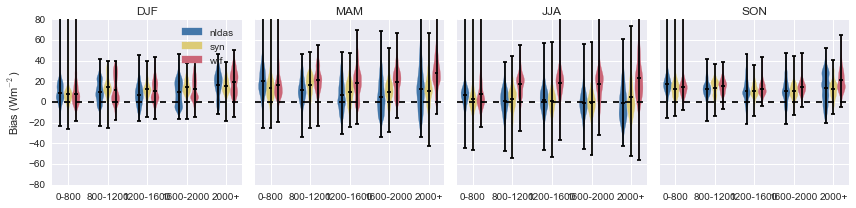

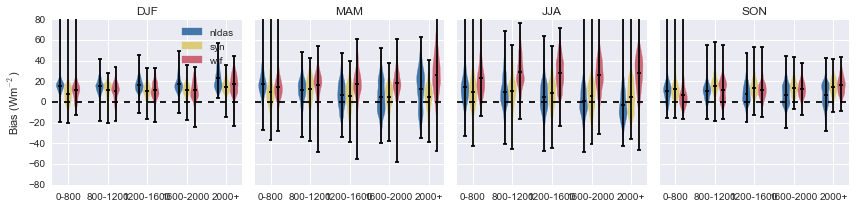

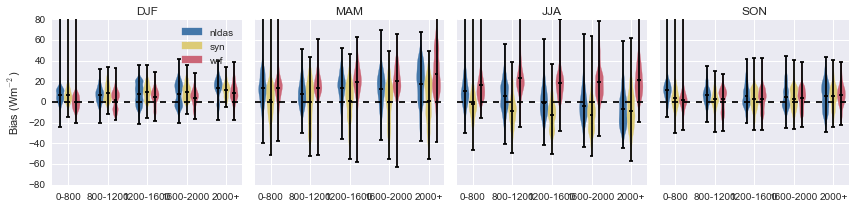

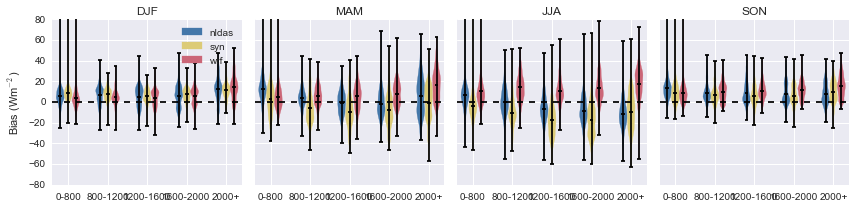

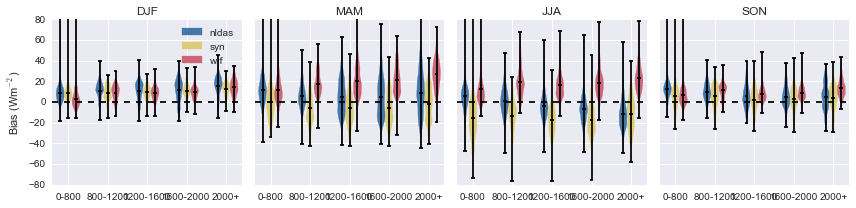

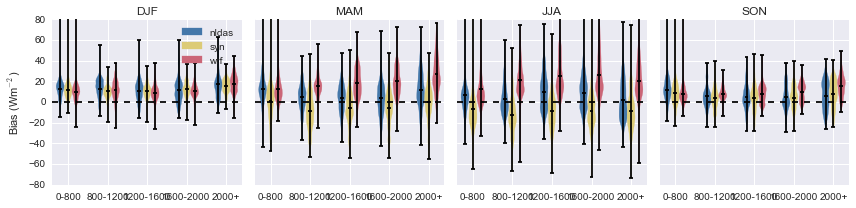

In [158]:
######################################################
## Monthly diff shortwave w/ elevation - histograms ##
######################################################
#### Organize data for plotting
## Difference structure
diff_ds = xray.Dataset()
for pr in pr_names:
    if pr == 'mtclim':
        continue
    # Difference
    diff_ds[pr] = align_ds[pr]-align_ds['mtclim']
    
## Digitize elevation
# bins = np.array((-100,50,100,800,1200,4000))
# bin_centers = np.array((25,75,450,1000,2600))
# bin_labels = ['0-50','50-100','100-800','800-1200','1200+']

bins = np.array((-100,800,1200,1600,2000,4000))
bin_centers = np.array((400,1000,1400,1800,3000))
bin_labels = ['0-800','800-1200','1200-1600','1600-2000','2000+']

nlat = diff_ds.latitude.size
nlon = diff_ds.longitude.size
ntime = diff_ds.time.size
diff_ds['elev'] = (('latitude','longitude'),wrf.elev.values[0,:,:])

elev = diff_ds.elev.values.flatten()
digitized = np.digitize(elev, bins)
bin_centers = np.append(bin_centers,np.nan)

## Reshape to 2D array of time x space
time = diff_ds.time
plot_ds = xray.Dataset()
## Reshape to 2D array of time x space
for pr in pr_names:
    if pr == 'mtclim':
        continue
    plot_ds[pr] = (('time','digi_elev'),diff_ds[pr].values.reshape((ntime,nlat*nlon)))    

plot_ds.coords['time'] = ('time',time)
plot_ds.coords['digi_elev'] = ('digi_elev',bin_centers[digitized-1])
# digi_elev = np.reshape(bin_centers[digitized-1],(nlat,nlon))
# diff_ds['digi_elev'] = (('latitude','longitude'),digi_elev)

#### Initial stab at necessary variables to define if I were to turn this into a function
bin_centers = bin_centers[:-1]
grouping = bin_centers
grouping_var = 'digi_elev'
grouping_labels = bin_labels

plotting_var = np.array(['nldas','syn','wrf'])
plot_interval = 'seasonal'
plot_period = np.arange(2004,2010)

# Formatting variables
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
season_label = ['DJF','MAM','JJA','SON']

colsche =   np.array([[68.,119.,170.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

pos_buffer = 2
num_pos = plotting_var.size
num_group = grouping.size
bin_pos = [np.linspace((num_pos+pos_buffer)*n+1,(num_pos+pos_buffer)*(n+1)-pos_buffer,\
            num=num_pos) for n in np.arange(num_group)]

violinplotlines = ['cbars','cmins','cmeans','cmaxes']


#### Violinplots
for YYYY in plot_period:
    if plot_interval == 'monthly':
        f, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)
    elif plot_interval == 'seasonal':
        f, axes = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
        
    for m,ax in enumerate(axes.flat):            
        ## Build xray Dataset for each product in interval, combine into a single array
        dat_for_plot = xray.Dataset()
        for pr_ind,pr in enumerate(plotting_var):            
            if plot_interval == 'monthly':
                if m == 11:
                    d = pd.date_range(start=(str(YYYY)+'-'+str(m+1)+'-1'),end=(str(YYYY+1)+'-'+str(1)+'-1'),freq='M')
                else:
                    d = pd.date_range(start=(str(YYYY)+'-'+str(m+1)+'-1'),end=(str(YYYY)+'-'+str(m+2)+'-1'),freq='M')
            elif plot_interval == 'seasonal':
                if m == 0:
                    d = pd.date_range(start=(str(YYYY-1)+'-'+str(12)+'-1'),freq='M',periods=3)
                else:
                    d = pd.date_range(start=(str(YYYY)+'-'+str((3*m))+'-1'),freq='M',periods=3)
            dat_for_plot[pr] = ((grouping_var),plot_ds[pr].loc[d[0]:d[-1]].values.flatten())
        if plot_interval == 'monthly':
            dat_for_plot.coords[grouping_var] = ((grouping_var),plot_ds[grouping_var].values)
        elif plot_interval == 'seasonal':
            # Flatten and append new index
            dat_for_plot.coords[grouping_var] = ((grouping_var),np.tile(plot_ds[grouping_var].values,3))
        
        # Drop nans
        dat_for_plot = dat_for_plot.dropna(grouping_var)
        # Combine separate data variables into single array
        dat_for_plot = combinevars(dat_for_plot,plotting_var,'product','diff')
                
        ## Violin plots
        for n,gr in enumerate(grouping):
            if not gr in dat_for_plot[grouping_var].values:
                continue
            group_for_plot = dat_for_plot.loc[{grouping_var:gr}].values
            if group_for_plot.size <= num_pos:
                continue
            result = ax.violinplot(group_for_plot.T,positions=np.array(bin_pos[n]),\
                                   showmeans=True,widths=1)
        
            ## Format
            # Violin body and label
            for n,pc in enumerate(result['bodies']):
                pc.set_facecolor(colsche[n])
                pc.set_edgecolor(colsche[n])
                pc.set_alpha(None)
            # Violinplot labels
            handle = [matplotlib.patches.Patch(color=colsche[n], label=plotting_var[n]) \
                      for n,p in enumerate(plotting_var)]
            # Violin lines
            pc = result['cbars']
            for vpl in violinplotlines:
                result[vpl].set_color('k')

            
        # Labels and legend
        if m == 0:
            ax.legend(handles=handle)
        ax.plot(np.array([0,24]),np.array([0,0]),'k--')
        ax.set_xticks(np.array(bin_pos)[:,1])
        ax.set_ylim([-80,80])
        if np.mod(((m)+4),4) == 0:
            ax.set_ylabel('Bias (Wm$^{-2}$)')
        if m > 8 and plot_interval == 'monthly':        
            ax.set_xticklabels(grouping_labels)
        elif plot_interval == 'seasonal':
            ax.set_xticklabels(grouping_labels)
        if plot_interval == 'monthly':
            ax.set_title(month_label[m]) 
        elif plot_interval == 'seasonal':
            ax.set_title(season_label[m])
    f.tight_layout()
    #     fname = 'ProdDiff.violin.'+str(YYYY)+'.png'
#     f.savefig(fname)
#     plt.close(f)
    
            